# Find wet vegetation (daily masking)

- Use wofs to mask daily imagery
- Calculate TCG and TCW
- Find daily wet vegetation
- Summarise monthly wet vegetation

### Import

In [1]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datacube.storage import masking

sys.path.append("Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
from dea_bandindices import calculate_indices
from dea_datahandling import wofs_fuser
from dea_dask import create_local_dask_cluster

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:36981' processes=1 threads=2, memory=14.18 GB>

In [3]:
dc = datacube.Datacube(app="Sentinel_2_burn_ratio")

### Get coordinates from tile
- Too big to load many images

In [4]:
tile = '11_-40'
# Define funciton to get tile bounds
def get_tile_bounds(tile):
    x, y = tile.split('_')
    minx = int(x) * 100000
    miny = int(y) * 100000
    maxx = minx + 100000
    maxy = miny + 100000
    return {'minx': minx, 'miny': miny, 'maxx': maxx, 'maxy': maxy}
bounds = get_tile_bounds(tile)
x=(bounds['minx'],bounds['maxx'])
y=(bounds['miny'],bounds['maxy'])

### Use coordinates to locate small area of interest

In [5]:
# Set the central latitude and longitude
# #Barmah
central_lat = -35.858473
central_lon = 145.023703

# # Mac Marshes
# central_lat = -30.698510
# central_lon = 147.534219

# # # Yorke
# central_lat = -34.211294
# central_lon =  137.774868

# # Arafura
# central_lat = -12.562990
# central_lon =  135.035205

# # Ayr
# central_lat = -19.371645
# central_lon =  146.922991

# # Burdekin
# central_lat = -19.926378 
# central_lon =  145.626075

# # Tas
# # central_lat = -42.019291
# # central_lon =  146.214005

# Set the buffer to load around the central coordinates
buffer = 0.2

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, crs='EPSG:4326', margin=-0.2)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

### Load WOFLS

In [6]:
# Create a reusable query
query = {
    "x": study_area_lon,
    "y": study_area_lat,
    "time": ('2016-01-01', '2016-12-31'),
    "output_crs": "EPSG:3577",
    "crs":'EPSG:4326',
    "resolution": (-25, 25),
    "group_by": "solar_day",
    "fuse_func": wofs_fuser,
}


# Load the data from the datacube
wofls = dc.load(product="wofs_albers", 
                dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
                **query)


In [7]:
wofls

<xarray.Dataset>
Dimensions:      (time: 40, x: 1619, y: 1915)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-03T00:10:40 ... 2016-12-13T00:...
  * y            (y) float64 -3.953e+06 -3.954e+06 ... -4.001e+06 -4.001e+06
  * x            (x) float64 1.154e+06 1.154e+06 ... 1.194e+06 1.194e+06
    spatial_ref  int32 3577
Data variables:
    water        (time, y, x) int16 dask.array<chunksize=(1, 1915, 1619), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [8]:
# Plot the loaded WOFLs
# wofls.water.plot(col="time", col_wrap=5)
# plt.show()

### Load surface reflectance

In [18]:
list(dc.list_products()['name'])

['camden_insar_alos_displacement',
 'fc_percentile_albers_annual',
 'fc_percentile_albers_seasonal',
 'ga_ls5t_ard_3',
 'ga_ls7e_ard_3',
 'ga_ls8c_ard_3',
 'ga_s2a_ard_nbar_granule',
 'ga_s2am_fractional_cover_2',
 'ga_s2b_ard_nbar_granule',
 'ga_s2bm_fractional_cover_2',
 'high_tide_comp_20p',
 'item_v2',
 'item_v2_conf',
 'landsat_barest_earth',
 'low_tide_comp_20p',
 'ls5_ard',
 'ls5_fc_albers',
 'ls5_level1_usgs',
 'ls5_nbart_geomedian_annual',
 'ls5_nbart_tmad_annual',
 'ls5_pq_albers',
 'ls5_usgs_l2c1',
 'ls7_ard',
 'ls7_fc_albers',
 'ls7_level1_usgs',
 'ls7_nbart_geomedian_annual',
 'ls7_nbart_tmad_annual',
 'ls7_pq_albers',
 'ls7_usgs_l2c1',
 'ls8_ard',
 'ls8_barest_earth_albers',
 'ls8_fc_albers',
 'ls8_level1_usgs',
 'ls8_nbart_geomedian_annual',
 'ls8_nbart_tmad_annual',
 'ls8_pq_albers',
 'ls8_usgs_l2c1',
 'mangrove_cover',
 'multi_scale_topographic_position',
 'nidem',
 's1_gamma0_geotif_scene',
 's2a_ard_granule',
 's2a_l1c_aws_pds',
 's2a_level1c_granule',
 's2a_nrt_gran

In [9]:
# Load a fractional cover (FC) tile to match the WOFLs data by using 'like'
# data = dc.load(product="ga_ls8c_ard_3", group_by="solar_day", 
#                measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
#                dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
#                like=wofls)

data = load_ard(dc=dc,
                min_gooddata=0.1,
                products=["ga_ls8c_ard_3"], 
                group_by="solar_day", 
                measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
                dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
                like=wofls)
# data

Scripts/dea_datahandling.py:209: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can significantly slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Loading ga_ls8c_ard_3 data
    Filtering to 12 out of 44 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 12 observations as a dask array


In [10]:
# data.nbart_red.plot(col="time", col_wrap=5)
# plt.show()

### Make cloud mask

In [11]:
# Make cloud free data
def cloud_free(data,wofls):
    # Remove milliseconds 
    data['time'] = data.indexes['time'].normalize()
    wofls['time'] = wofls.indexes['time'].normalize()

    # Find duplicates
    wofls_dates = wofls['time'].isin(data['time'].values)

    # Only select NRT that is not duplicated in ARD
    wofls_sel = wofls.sel(time=wofls_dates)
    # wofls_sel

    # Removing clouds and their shadows
    clear = {"cloud_shadow": False, "cloud": False, "nodata":False, "noncontiguous": False}

    cloudfree = masking.make_mask(wofls_sel, **clear)
    cloudfree_data = data.where(cloudfree.water == True)
    # cloudfree_data.nbart_red.plot()
    # plt.show()
    return cloudfree_data

In [12]:
cloudfree_data = cloud_free(data,wofls)

### Calculate TCG and TCW

In [13]:
cloudfree_data = calculate_indices( cloudfree_data, 
                          index='TCW', 
                          collection='ga_ls_3', 
                          normalise=False,
                          drop=False)

cloudfree_data = calculate_indices( cloudfree_data, 
                          index='TCG', 
                          collection='ga_ls_3', 
                          normalise=False,
                          drop=False)

Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "
Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCG') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


### Calculate daily wet vegetation

In [14]:
green = cloudfree_data.TCG > 1000
wet = cloudfree_data.TCW > -350
not_green= wet.where(green != 1,0,0)

not_green = not_green.groupby('time.month').max(dim='time')  
# not_green = np.where(green.TCG != 1, wet.TCW, 0)
# not_green = (green.TCG != 1) & wet.TCW #green.TCG & wet.TCW


### Plot image
- Save out image

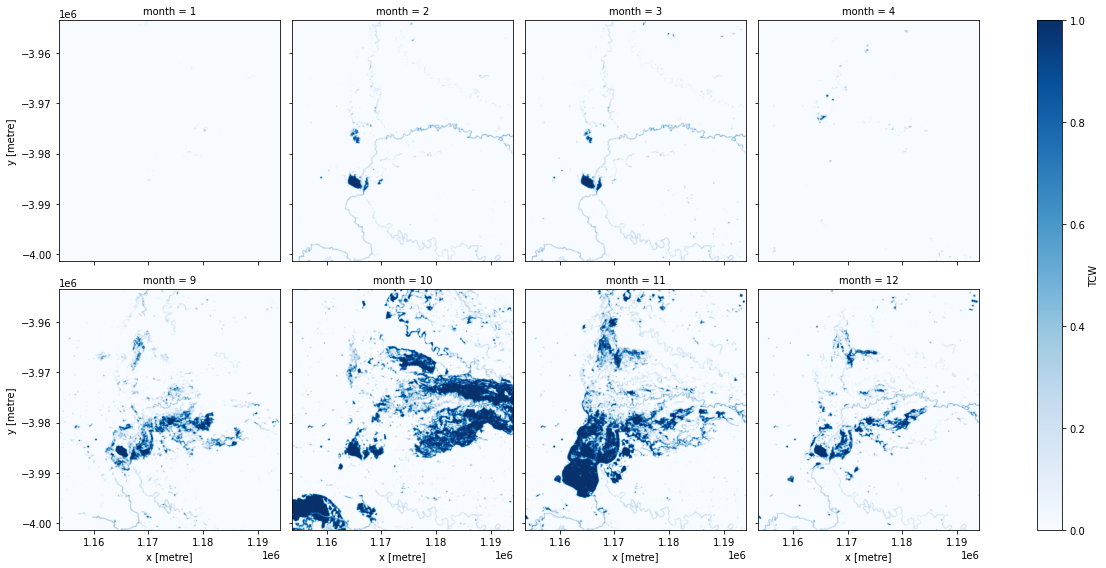

In [15]:
not_green.plot.imshow(col="month", cmap='Blues', col_wrap=4, size=4,interpolation='gaussian')
# fig = not_green.plot(col="month", cmap='Blues', col_wrap=4, size=4)
# plt.savefig('foo.png')

### Annual statistics

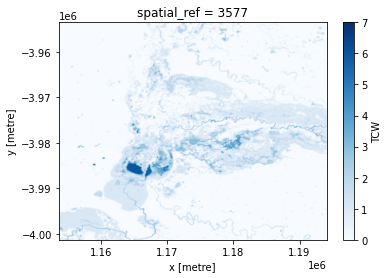

In [16]:
freq = not_green.sum(dim='month')
freq.plot.imshow(cmap='Blues',interpolation='gaussian')

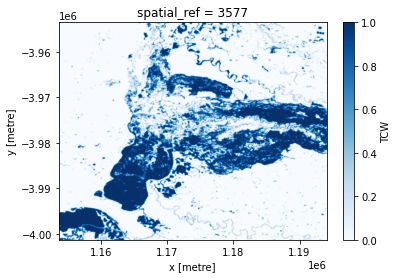

In [17]:
year_max = (freq >= 1)
year_max.plot.imshow(cmap='Blues',interpolation='gaussian')